In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, make_scorer, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm
from dataprep import *
import anndata as ad
import pickle
import seaborn as sns

In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)


custom = {"axes.edgecolor": "grey"}
sns.set_style("whitegrid")
plt.rcParams['grid.alpha'] = 0.4
sns.set_palette("colorblind")
colorblind_palette = sns.color_palette("colorblind")
# Like colorblind_palette[4] for control, colorblind_palette[0] for test

## Loading RF Models & Datasets

Paths to pericellular/other patterns RF models

In [ ]:
# balanced RF based on mixed ID embeddings.
path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_mixedID.pkl"
with open(path, 'rb') as p:
    rf_classifier_balanced_mixed = pickle.load(p)

# balanced RF based on splt ID embeddings.
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_splitID.pkl"
with open(path1, 'rb') as p:
    rf_classifier_balanced_split = pickle.load(p)

# Model I used 25/04 to create the figures that looked different based on the dataset used.
path2 = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern.pkl"
with open(path2, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

In [4]:
# balanced RF based on splt ID embeddings with cell2 conda environment --> newer scikit-learn version.
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_splitID_conda_cell2.pkl"
with open(path1, 'rb') as p:
    rf_classifier_balanced_split = pickle.load(p)

In [3]:
#adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [4]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
choices = ['strong', 'intermediate', 'low']
for adata in [adata_split_cellID, adata_mixed_cellID]: #, adata_all_spots
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]

    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

# Code I used to generate the RFs

## Preprocessing data

In [5]:
# Decided to use "no pattern" iso "random" for pattern versus no pattern classifier. 
adata_split_cellID.obs['random_or_pattern'] = adata_split_cellID.obs['random_or_pattern'].replace('random','nonpattern')
adata_mixed_cellID.obs['random_or_pattern'] = adata_mixed_cellID.obs['random_or_pattern'].replace('random','nonpattern')

In [6]:
adata_split_strong = adata_split_cellID[adata_split_cellID.obs['pattern_strength']=='strong']
adata_mixed_strong = adata_mixed_cellID[adata_mixed_cellID.obs['pattern_strength']=='strong']

adata_train_split = adata_split_strong[adata_split_strong.obs['cell_id'].isin(adata_split_strong.uns['train_cellIDs'])]
adata_test_split = adata_split_strong[adata_split_strong.obs['cell_id'].isin(adata_split_strong.uns['test_cellIDs'])]

adata_train_mixed = adata_mixed_strong[adata_mixed_strong.obs['cell_id'].isin(adata_split_strong.uns['train_cellIDs'])]
adata_test_mixed = adata_mixed_strong[adata_mixed_strong.obs['cell_id'].isin(adata_split_strong.uns['test_cellIDs'])]

### Pericellular RF

In [8]:
def initialize_training_adata(adata, test_pattern: int = 'pericellular', balanced: bool = True, include_random: bool = False):
    for pattern in adata.obs["pattern"].unique():
        adata.obs[pattern] = np.where(adata.obs["pattern"] == pattern, pattern, "other")

    adata_train = adata[adata.obs['cell_id'].isin(adata.uns['train_cellIDs'])]
    adata_test = adata[adata.obs['cell_id'].isin(adata.uns['test_cellIDs'])]

    if balanced:
        if include_random:
            adata_train = balanceTrainingData(adata_train, testPattern = test_pattern, include_random = True, random_seed = seed)
            adata_test = balanceTrainingData(adata_test, testPattern = test_pattern, include_random = True, random_seed = seed)
        else:
            adata_train = balanceTrainingData(adata_train, testPattern = test_pattern, include_random = False, random_seed = seed)
            adata_test = balanceTrainingData(adata_test, testPattern = test_pattern, include_random = False, random_seed = seed)
    
    return adata_train, adata_test


In [9]:
def train_RF(adata_train, adata_test, classes: str = "pericellular", n_jobs: int = 4):
    rf = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = n_jobs)
    rf.fit(adata_train.obsm["latent"], adata_train.obs[classes]) 
    
    pred_probabilities = rf.predict_proba(adata_test.obsm["latent"])

    print(f"auc: {classes}", roc_auc_score(adata_test.obs[classes], pred_probabilities[:,1]))

    return rf

In [17]:
adata_train, adata_test = initialize_training_adata(adata_split_strong, test_pattern = "pericellular", balanced = False, include_random=False)
    
rf_unbalanced = train_RF(adata_train, adata_test, classes = "pericellular", n_jobs = 4)

path = f"temp_objects/rf_balanced/pattern_vs_other/cell2_pericellular_unbalanced.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_unbalanced, f)

auc: pericellular 0.9958718346736607


In [ ]:
path = f"temp_objects/rf_balanced/pattern_vs_other/cell2_pericellular_balanced.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_balanced, f)

In [18]:
rf_balanced

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

In [16]:
rf_balanced
rf_balanced_inclRandom
rf_unbalanced

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

/tmp/ipykernel_166225/1617139924.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test_allstrengths.obs['pericellular'] = np.where(adata_test_allstrengths.obs["pattern"] == 'pericellular', 'pericellular', "other")


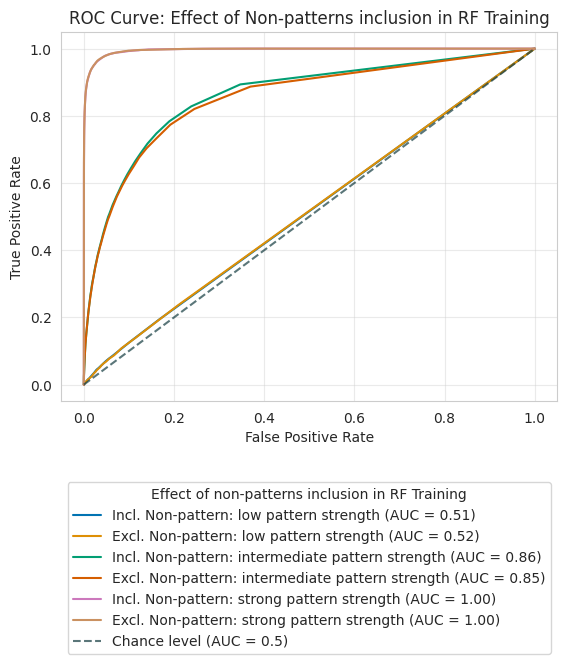

In [28]:
adata_test_allstrengths = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]
adata_test_allstrengths.obs['pericellular'] = np.where(adata_test_allstrengths.obs["pattern"] == 'pericellular', 'pericellular', "other")
pattern_strength = ["low", "intermediate", "strong"]
# 'unbalanced': rf_peri_unbalanced, 'balanced': rf_peri_balanced, 'unbalanced_inclRandom': rf_peri_balanced_inclRandom
models= {"Incl. Non-pattern: ": rf_balanced_inclRandom,"Excl. Non-pattern: ": rf_balanced}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = adata_test_allstrengths[adata_test_allstrengths.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = f"{name}{strength} pattern strength",
            ax=ax,
            plot_chance_level=True if ((strength == 'strong')&(model==rf_balanced)) else False,
            chance_level_kw={'color': '#143C40', 'alpha': 0.7})
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve: Effect of Non-patterns inclusion in RF Training"
    )
plt.legend(title="Effect of non-patterns inclusion in RF Training", bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

In [39]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]
adata_test.obs['rna_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)
adata_test.obs['pericellular'] = np.where(adata_test.obs["pattern"] == 'pericellular', 'pericellular', "other")

adatas_inclRandom = {}
adatas_exclRandom = {}
for strength in ['low', 'intermediate', 'strong']:
    adata_strength = adata_test[adata_test.obs['pattern_strength']==strength]
    adatas_inclRandom[strength] = balanceTrainingData(adata_strength, testPattern = 'pericellular', include_random = True, random_seed = seed)
    adatas_exclRandom[strength] = balanceTrainingData(adata_strength, testPattern = 'pericellular', include_random = False, random_seed = seed)

/tmp/ipykernel_166225/3099283680.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['rna_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)
/media/gambino/students_workdir/nynke/blurry/dataprep.py:274: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pattern_groups = adata_control.obs.groupby('pattern')
/media/gambino/students_workdir/nynke/blurry/dataprep.py:274: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pattern_groups = adata_control.obs.groupby('pattern')
/media/gambino/students_workdir/nynke/blurry/dataprep.py:274: Fut

In [33]:
adata_test

AnnData object with n_obs × n_vars = 329349 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count', 'pericellular'
    uns: 'test_cellIDs', 'train_cellIDs'
    obsm: 'latent'

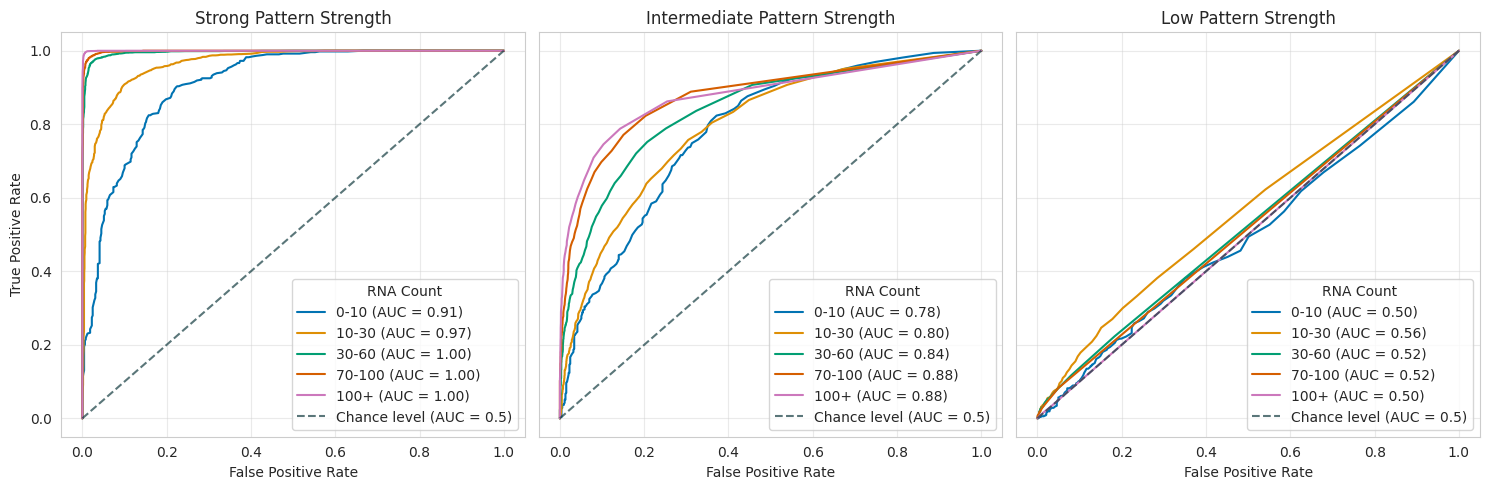

In [46]:
intervals = ['0-10','10-30','30-60', '70-100','100+']
predictions = {}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, strength in enumerate(['strong', 'intermediate', 'low']):
    ax = axs[i]  # Select the subplot for the current strength
    adata_strength = adatas_exclRandom[strength]
    for interval in intervals:
        adata_counts = adata_strength[adata_strength.obs['rna_count']==interval]
        test_pred = rf_balanced_inclRandom.predict_proba(adata_counts.obsm["latent"])[:,1]
        predictions[interval] = RocCurveDisplay.from_predictions(
            adata_counts.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = interval,
            ax=ax,
            plot_chance_level=True if interval == '100+' else False,
            chance_level_kw={'color': '#143C40', 'alpha': 0.7})
    ax.set(
        xlabel = "False Positive Rate",
        title = f"{strength.capitalize()} Pattern Strength")
    if i != 0:  # Remove the x-label for the non-left plots
        ax.set(ylabel="")
        ax.set_yticklabels([])
    else:  # Set the x-label for the left-most plot
        ax.set(ylabel = "True Positive Rate")
    #ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='Chance Level')  # Plot the chance level line
    
    ax.legend(title="RNA Count", loc='lower right')



plt.tight_layout(w_pad=1)
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

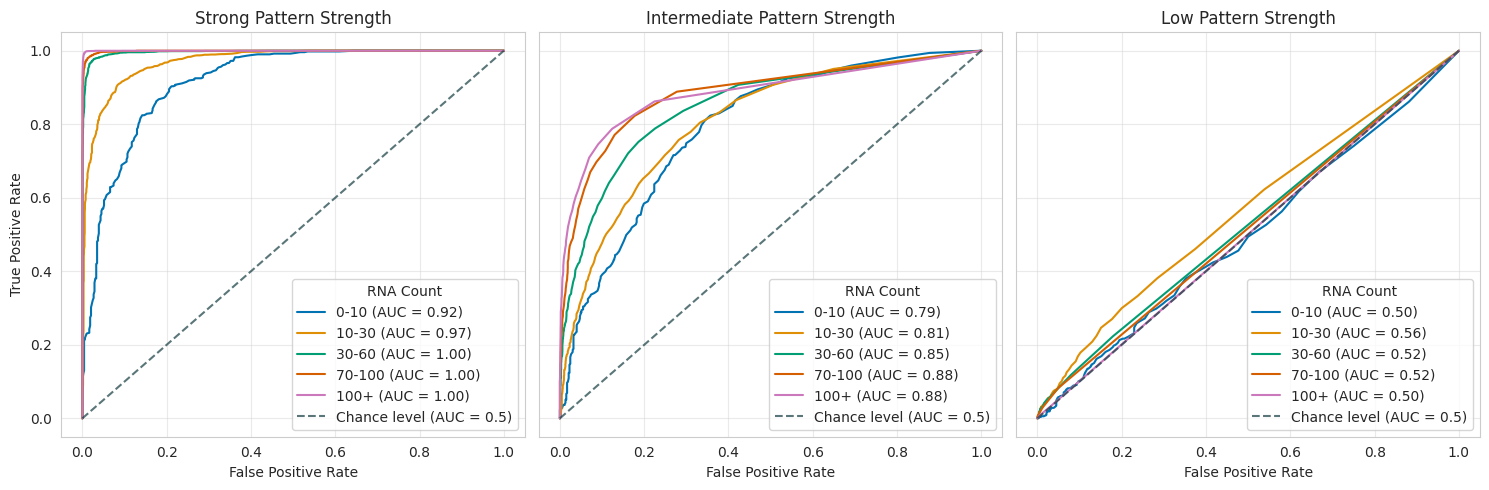

In [45]:
intervals = ['0-10','10-30','30-60', '70-100','100+']
predictions = {}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, strength in enumerate(['strong', 'intermediate', 'low']):
    ax = axs[i]  # Select the subplot for the current strength
    adata_strength = adatas_inclRandom[strength]
    for interval in intervals:
        adata_counts = adata_strength[adata_strength.obs['rna_count']==interval]
        test_pred = rf_balanced_inclRandom.predict_proba(adata_counts.obsm["latent"])[:,1]
        predictions[interval] = RocCurveDisplay.from_predictions(
            adata_counts.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = interval,
            ax=ax,
            plot_chance_level=True if interval == '100+' else False,
            chance_level_kw={'color': '#143C40', 'alpha': 0.7})
    ax.set(
        xlabel = "False Positive Rate",
        title = f"{strength.capitalize()} Pattern Strength")
    if i != 0:  # Remove the x-label for the non-left plots
        ax.set(ylabel="")
        ax.set_yticklabels([])
    else:  # Set the x-label for the left-most plot
        ax.set(ylabel = "True Positive Rate")
    #ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='Chance Level')  # Plot the chance level line
    
    ax.legend(title="RNA Count", loc='lower right')



plt.tight_layout(w_pad=1)
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

### Pattern / No pattern RF

In [10]:
# Balancing the training sets. 
adata_train_balanced_split = balanceTrainingData_pattern_noPattern(adata_train_split, random_seed=seed)
adata_test_balanced_split = balanceTrainingData_pattern_noPattern(adata_test_split, random_seed=seed)
adata_train_balanced_mixed = balanceTrainingData_pattern_noPattern(adata_train_mixed, random_seed=seed)
adata_test_balanced_mixed = balanceTrainingData_pattern_noPattern(adata_test_mixed, random_seed=seed)

In [11]:
# create random forest classifier and fit on training data
rf_classifier_balanced_split = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_classifier_balanced_split.fit(adata_train_balanced_split.obsm["latent"], adata_train_balanced_split.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

In [10]:
# create random forest classifier and fit on training data
rf_classifier_balanced_mixed = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_classifier_balanced_mixed.fit(adata_train_balanced_mixed.obsm["latent"], adata_train_balanced_mixed.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

### Saving the models

In [12]:
import pickle

path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_mixedID.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_classifier_balanced_mixed, f)

In [43]:
path = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_balanced_splitID_conda_cell2.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_classifier_balanced_split, f)

# Generating the Histograms

Based on the Dictionaries created above, this code snippet creates a dataframe with the RF classification probabilities of the different models for the different datasets. The histograms below include 10 of these genes, hence the range(10). 

Predict_proba returns a nx2 array, where the two columns are the probabilities for [nonpattern, pattern], hence the [:,1]

#### Pattern versus nonpattern graphs

In [31]:
rows = []

split_pattern = adata_test_split[(adata_test_split.obs['random_or_pattern']=='pattern')]
split_no_pattern = adata_test_split[adata_test_split.obs['random_or_pattern']=='nonpattern']
mixed_pattern = adata_test_mixed[adata_test_mixed.obs['random_or_pattern']=='pattern']
mixed_no_pattern = adata_test_mixed[adata_test_mixed.obs['random_or_pattern']=='nonpattern']

for model in [rf_classifier_balanced_split, rf_classifier_balanced_mixed]:
    split_patterned = model.predict_proba(split_pattern.obsm["latent"])[:,1]
    split_nopatterned = model.predict_proba(split_no_pattern.obsm["latent"])[:,1]
    mixed_patterned = model.predict_proba(mixed_pattern.obsm["latent"])[:,1]
    mixed_nopatterned = model.predict_proba(mixed_no_pattern.obsm["latent"])[:,1]
    for value in split_patterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'split_pattern'})
    for value in split_nopatterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'split_no_pattern'})
    for value in mixed_patterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'mixed_pattern'})
    for value in mixed_nopatterned:
        rows.append({'prob_pattern': value, 'model':model, 'group': 'mixed_no_pattern'})
df = pd.DataFrame(rows)

/media/gambino/students_workdir/nynke/blurry/images/embedding_pictures/splitData_splitRF.png

201
201


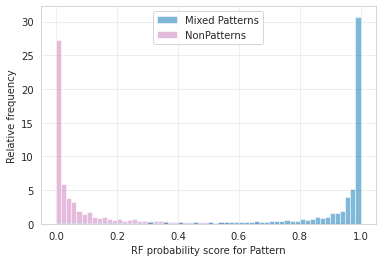

In [93]:
pattern = ['split_pattern','mixed_pattern']
nonpattern = ['split_no_pattern','mixed_no_pattern']
# rf pattern balanced is the model I used to generate the figures in April
models = [rf_classifier_balanced_split, rf_classifier_balanced_mixed]
model = ['Split Embedding', 'Mixed Embedding']

test = df[(df['group']==pattern[0])&(df['model']==models[0])]
control = df[(df['group']==nonpattern[0])&(df['model']==models[0])]

print(len(control['prob_pattern'].unique()))
print(len(test['prob_pattern'].unique()))


plt.hist(control['prob_pattern'], bins=60, alpha=0.5, label='NonPatterns', density=True, color=colorblind_palette[4])
plt.hist(test['prob_pattern'], bins=60, alpha=0.5, label='Mixed Patterns', density=True, color=colorblind_palette[0])


# Get the handles and labels from the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Sort them together based on the labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))

# Set the legend again with the sorted handles and labels
plt.legend(handles, labels, loc='upper center')

plt.xlabel("RF probability score for Pattern")
plt.ylabel("Relative frequency")
plt.show()

# AUC curves

In [12]:
rf_classifier_balanced_split

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

In [7]:
def map_interval(interval):
    if interval == '0-10':
        return '0-10'
    elif interval in ['10-20', '20-30']:
        return '10-30'
    elif interval in ['30-40', '40-50', '50-60']:
        return '30-60'
    elif interval in ['70-80', '80-90', '90-100']:
        return '70-100'
    elif interval == '100+':
        return '100+'
    else:
        return None

In [19]:
adata_test.obs['random_or_pattern'].unique()

['pattern', 'random']
Categories (2, object): ['pattern', 'random']

In [20]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]
adata_test.obs['rna_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)

adatas = {}
for strength in ['low', 'intermediate', 'strong']:
    adata_strength = adata_test[adata_test.obs['pattern_strength']==strength]
    adatas[strength] = balanceTrainingData_pattern_noPattern(adata_strength, random_seed=seed)


/tmp/ipykernel_20326/1999005000.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs['rna_count'] = adata_test.obs['n_spots_interval'].apply(map_interval)


In [21]:
adatas

{'low': AnnData object with n_obs × n_vars = 25454 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count'
     obsm: 'latent',
 'intermediate': AnnData object with n_obs × n_vars = 25478 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count'
     obsm: 'latent',
 'strong': AnnData object with n_obs × n_vars = 25464 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength', 'rna_count'
     obsm: 'late

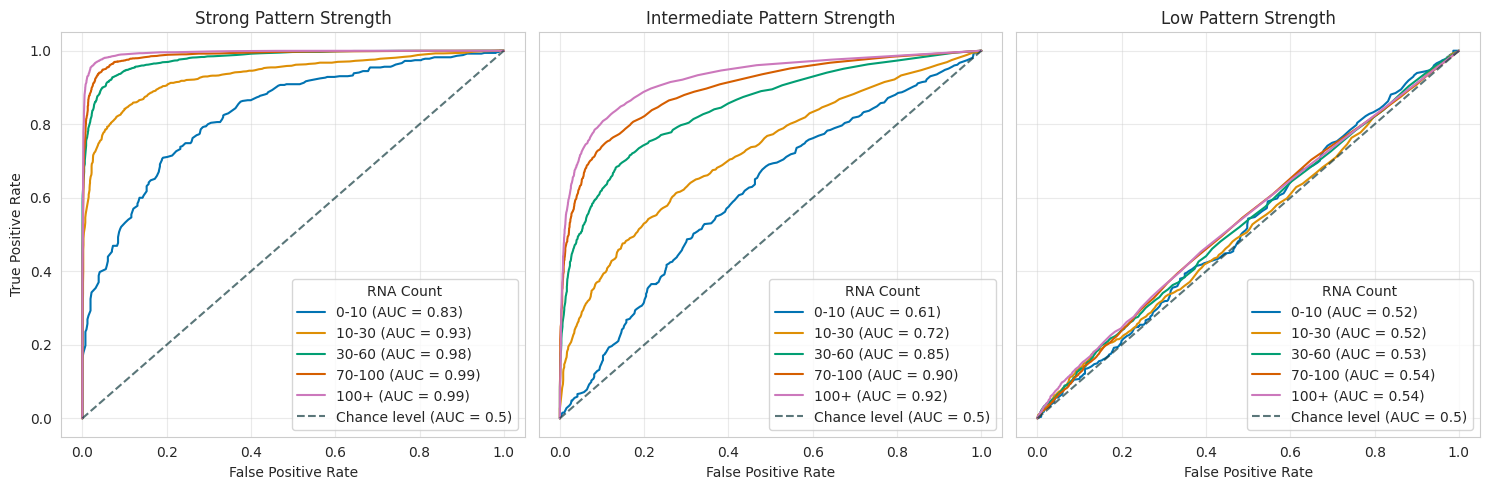

In [28]:
intervals = ['0-10','10-30','30-60', '70-100','100+']
predictions = {}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, strength in enumerate(['strong', 'intermediate', 'low']):
    ax = axs[i]  # Select the subplot for the current strength
    adata_strength = adatas[strength]
    for interval in intervals:
        adata_counts = adata_strength[adata_strength.obs['rna_count']==interval]
        test_pred = rf_classifier_balanced_split.predict_proba(adata_counts.obsm["latent"])[:,1]
        predictions[interval] = RocCurveDisplay.from_predictions(
            adata_counts.obs['random_or_pattern'],
            test_pred, 
            pos_label = "pattern",
            name = interval,
            ax=ax,
            plot_chance_level=True if interval == '100+' else False,
            chance_level_kw={'color': '#143C40', 'alpha': 0.7})
    ax.set(
        xlabel = "False Positive Rate",
        title = f"{strength.capitalize()} Pattern Strength")
    if i != 0:  # Remove the x-label for the non-left plots
        ax.set(ylabel="")
        ax.set_yticklabels([])
    else:  # Set the x-label for the left-most plot
        ax.set(ylabel = "True Positive Rate")
    #ax.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), label='Chance Level')  # Plot the chance level line
    
    ax.legend(title="RNA Count", loc='lower right')



plt.tight_layout(w_pad=1)
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()